In [152]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
# from sklearn import preprocessing
# pip install -U finance-datareader
# import FinanceDataReader as fdr
def make_sequence_dataset(feature, label, window_size):
    feature_list = [] 
    label_list = []

    for i in range(len(feature) - window_size):
        feature_list.append(feature[i:i+window_size+1]) # added label
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

def survive_open(x):
    for i in range(len(x)):
        x[i][40][1:] = np.zeros(7)
    return x

raw_df = pd.read_csv('test4.csv')

# 정규화 작업

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low' , 'Close', 'Adj Close', '3MA','5MA','Volume']
scaled_df = scaler.fit_transform(raw_df[scale_cols]) # scaler.inverse_transform(X)

scaled_df = pd.DataFrame(scaled_df , columns=scale_cols)


feature_cols = ['Open', 'High', 'Low' , 'Close', 'Adj Close', '3MA','5MA','Volume']
label_cols = ['High','Low']

label_np   = pd.DataFrame(scaled_df, columns=label_cols).to_numpy()
feature_np = pd.DataFrame(scaled_df, columns = feature_cols).to_numpy()

window_size = 40
x,y = make_sequence_dataset(feature_np, label_np, window_size)
x = survive_open(x) # 


from sklearn.model_selection import train_test_split
xtr,xte,ytr,yte = train_test_split(x,y,train_size=0.4,shuffle=False) #train:val:test = 4:3:3 ≈ 1186:890:890
xval, xte, yval, yte = train_test_split(xte, yte, test_size=0.5, random_state=10) 

### Modeling and Training 

In [175]:
model = Sequential()
model.add( LSTM(128,
             activation = 'tanh',
             input_shape = xtr[0].shape)) #41,8

model.add(Dense (64, activation = 'linear'))
model.add(Dense (2, activation = 'linear'))
model.summary()
# 모델 컴파일 및 학습

model.compile(loss='mse', optimizer='adam', metrics=['mae','acc'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(xtr,ytr, validation_data=(xval,yval), epochs=40,batch_size=16,callbacks=[early_stop])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 78,530
Trainable params: 78,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
75/75 [==============================] - 1s 7ms/step - loss: 4.3501e-05 - mae: 0.0038 - acc: 0.5809 - val_loss: 5.1064e-04 - val_mae: 0.0117 - val_acc: 0.7629
Epoch 2/40
75/75 [==============================] - 0s 5ms/step - loss: 1.1105e-06 - mae: 7.7913e-04 - acc: 0.7336 - val_loss: 8.1031e-04 - val_mae: 0.0152 - val_acc: 0.4551
Epoch 3/40
75/75 [==================

### Evaluation on Test set 

In [176]:
def inverse_scaling(pre,scaler=scaler,feature_cols=feature_cols,label_cols=label_cols):
    index = []
    zeros = np.zeros( (pre.shape[0],len(feature_cols)) )
    for item in label_cols:
        index.append(feature_cols.index(item) )
    zeros[:,index] = pre
    inverse_pred = scaler.inverse_transform(zeros)[:,index]
    return inverse_pred

pred = model.predict(xte)
pred = inverse_scaling(pred)
yte  = inverse_scaling(yte)
pred_high,pred_low = pred[:,0],pred[:,1]
high,low = yte[:,0],yte[:,1]

In [177]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
mae(pred_high,high)

0.7600397341183611

### Visualization 

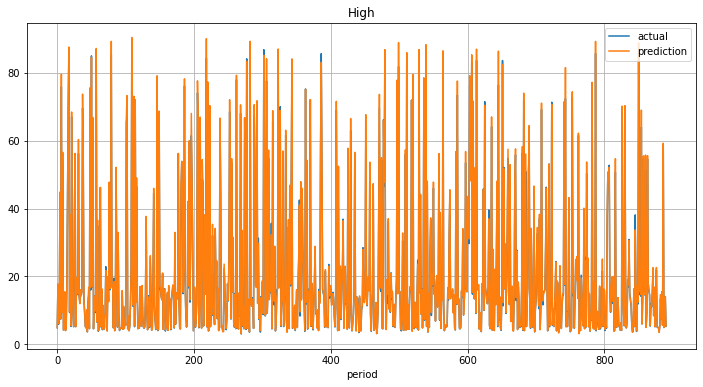

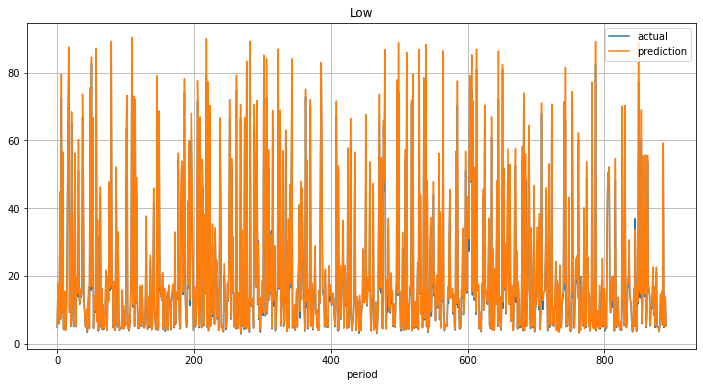

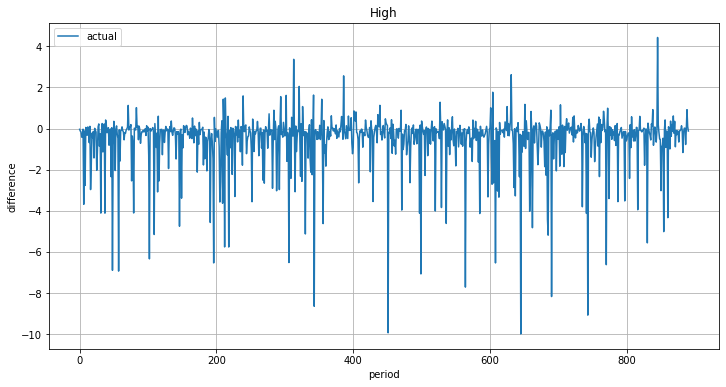

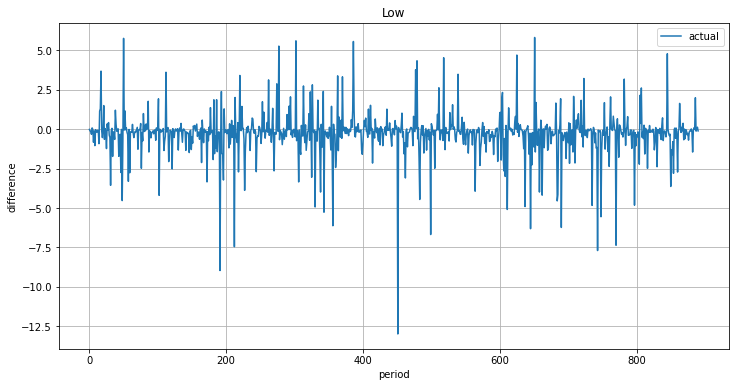

In [186]:
plt.figure(figsize=(12,6))
plt.title('High')
plt.ylabel('')
plt.xlabel('period')
plt.plot(yte[:,0], label='actual')
plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()

plt.figure(figsize=(12,6))
plt.title('Low')
plt.ylabel('')
plt.xlabel('period')
plt.plot(yte[:,1], label='actual')
plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()

plt.figure(figsize=(12,6))
plt.title('High')
plt.ylabel('difference')
plt.xlabel('period')
plt.plot(high-pred_high, label='actual')
# plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()

plt.figure(figsize=(12,6))
plt.title('Low')
plt.ylabel('difference')
plt.xlabel('period')
plt.plot(low-pred_low, label='actual')
# plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()